In [1]:
# %matplotlib widget
import warnings, os, pathlib, shutil, copy, requests, zipfile, dataclasses, us, hashlib, humanfriendly as hf, codetiming
import numpy as np, pandas as pd, geopandas as gpd, networkx as nx, cudf, cugraph as cugr, h5py
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px

#################################################
### Convenience and helpers ###
#################################################
os.environ['PROJ_LIB']  = '/home/pythonserver/miniconda3/envs/rapids/share/proj'
path_root = pathlib.Path('/home/pythonserver/gerrymandering')
path_in = path_root / 'input'
path_out = path_root / 'output'
[warnings.filterwarnings(action='ignore', message=f".*{w}.*") for w in [
    "Could not infer format, so each element will be parsed individually, falling back to `dateutil`",
    "Engine has switched to 'python' because numexpr does not support extension array dtypes",
    "Specify dtype option on import or set low_memory=False",
    "The default of observed=False is deprecated and will be changed to True in a future version of pandas",
    "errors='ignore' is deprecated and will raise in a future version",
    "Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'",
]]
def restart(self):
    self._start_time = None
    self.start()
codetiming.Timer.restart = restart
timer = codetiming.Timer(text=hf.format_timespan)


def listify(*args):
    if len(args)==1:
        if args[0] in [None, np.nan, '']:
            return list()
        elif isinstance(args[0], str):
            return [args[0]]
    try:
        return list(*args)
    except:
        return list(args)

def pattern(x, y, pre=None, suf=None):
    p = [len(z) for z in str(y).split('.')]
    pre = str(pre if pre is not None else ' ')
    suf = str(suf if suf is not None else 0)
    x = [str(int(x))] if len(p)==1 else str(round(float(x), p[1])).split('.')
    x[0] = x[0].rjust(p[0], pre)
    if len(p) > 1:
        x[1] = x[1].ljust(p[1], suf)[:p[1]]
    return '.'.join(x)

now = lambda: str(pd.Timestamp.utcnow())[:-13].replace(' ','_')
drop = lambda src, drp: type(src)({k:v for k,v in (src if isinstance(src,dict) else dict(zip(src,src))).items() if k not in listify(drp)})
join = lambda x, s=' ': str(s).join([str(y) for y in listify(x)])


def disp(X, rows=6, cols=None):
    with pd.option_context('display.min_rows', rows, 'display.max_rows', rows, 'display.max_columns', cols):
        display(X)
pd.DataFrame.disp = disp
pd.Series.disp = disp


def convert(ser, bools=[], cat=False, force_int64=True, dtype_backend='numpy_nullable'):
    """overly complicated preprocessor for dtype tricks"""
    ser = ser.convert_dtypes(dtype_backend)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if isinstance(ser.dtype, pd.BooleanDtype) or pd.api.types.is_datetime64_any_dtype(ser) or pd.api.types.is_timedelta64_dtype(ser):  #no action
            pass
        elif pd.api.types.is_numeric_dtype(ser):  #attempt to downcast numerical
            ser = pd.to_numeric(ser, downcast='unsigned')
        elif pd.api.types.is_string_dtype(ser) or pd.api.types.is_object_dtype(ser):  #prep strings
            ser = ser.astype('string')
            try:  # is it a datetime  hiding as string?
                ser = pd.to_datetime(ser)
            except:  # is it a number hiding as string?
                try:
                    ser = pd.to_numeric(ser, downcast='unsigned')
                except:  # it must be a real string - lower case it and fill blanks with pd.NA
                    ser = ser.str.lower().replace('', pd.NA)
                    if cat:  # make pandas categorical if cat=True
                        ser = ser.astype('category')
    if force_int64 and pd.api.types.is_integer_dtype(ser):  # to_numeric likes to downcast to Int 32 or Int16, which often causes problems later, so explicitly upcast to Int64
        ser = ser.astype('Int64')
    if ser.name in bools:  # make boolean if in list of bools
        ser = (ser == ser.max()).astype('boolean').fillna(False)
    return ser.convert_dtypes(dtype_backend)


def prep(X, **kwargs):
    f = lambda s: s.lower().replace(' ','_').replace('-','_') if isinstance(s, str) else s  # column renamer
    g = lambda x: gpd.GeoDataFrame(x).rename(columns=f).apply(convert, **kwargs)  # ensure X is a geodataframe, rename its columns, and apply convert to its columns
    df = g(X)
    idx = g(df[[]].reset_index())  # drop columns, reset_index to move index to columns, then apply g
    df = df.set_index(pd.MultiIndex.from_frame(idx))  # set idx back to df's index
    Z = df.squeeze() if isinstance(X, pd.Series) else df  # squeeze to series if input was series
#     display(type(Z), Z.shape, Z.dtypes)
    return Z
pd.DataFrame.prep = prep
pd.Series.prep = prep
gpd.GeoDataFrame.prep = prep
gpd.GeoSeries.prep = prep


def get_mlt(S, grp='geoid20'):
    A = S / S.groupby(grp).transform('sum').replace(0,pd.NA)
    N = 1 / S.groupby(grp).transform('size')
    return A.combine_first(N).rename('mlt').to_frame().prep()
pd.DataFrame.get_mlt = get_mlt
pd.Series.get_mlt = get_mlt


def apply_mlt(df, mlt='mlt', col=None):
    mlt = df.pop(mlt).to_frame().values
    col = df.columns.tolist() if col is None else listify(col)
    df[col] *= mlt
    return df
pd.DataFrame.apply_mlt = apply_mlt


def rm(path, root=True):
    if path.is_file():
        p.unlink()
    elif path.is_dir():
        if root:
            shutil.rmtree(path)
        else:
            for p in path.iterdir():
                rm(p)
    # else:
    #     print(path, 'not found')


def fetch(url, fn):
    fn = pathlib.Path(fn)
    fn.parent.mkdir(parents=True, exist_ok=True)
    if not fn.exists():
        print(url)
        with open(fn, "wb") as f:
            f.write(requests.get(url).content)
    return fn


def fetch_zip(url, fn, path=None):
    fn = fetch(url, fn)
    zipfile.ZipFile(fn).extractall(fn.parent if path is None else path)
    return fn


def load_h5py(fn, **kwargs):
    with h5py.File(fn, 'r', **kwargs) as f:
        dct = {k: v[:] for k,v in f.items()}
    return dct


def load(fn, **kwargs):
    prep_kwargs = {k:kwargs.pop(k) for k in ['bools','cat'] if k in kwargs}
    for read in [gpd.read_parquet, pd.read_parquet, pd.read_csv, gpd.read_file, load_h5py]:
        try:
            X = read(fn, **kwargs)
            break
        except:
            X = None
    try:
        return X.prep(**prep_kwargs)
    except:
        return X

def dump(fn, X, **kwargs):
    fn = pathlib.Path(fn)
    fn.parent.mkdir(parents=True, exist_ok=True)
    X = X.prep(cat=True)
    X.to_parquet(fn, **kwargs)
    return X


@dataclasses.dataclass
class MyBaseClass():
    def __contains__(self, key):
        return hasattr(self, key)
    def __getitem__(self, key):
        return getattr(self, key)
    def __setitem__(self, key, val):
        setattr(self, key, val)
    def __delitem__(self, key):
        delattr(self, key)


@dataclasses.dataclass
class Redistrict(MyBaseClass):
    st: str = 'tx'
    years: tuple = tuple(range(2014,2023))
    dst: str = 'sd'
    overwrite: tuple = ()

    # def pq(self, x):
    #     pq = path_out / f"{self.st}/{x}/{x}.parquet"
    #     pq.parent.mkdir(parents=True, exist_ok=True)
    #     return pq

    
    def pq(self, *x):
        pq = path_out / f"{self.st}/{join(x,'/')}/{x[-1]}.parquet"
        pq.parent.mkdir(parents=True, exist_ok=True)
        return pq


    def __post_init__(self):
        self.state = us.states.lookup(self.st).name
        self.fips  = us.states.lookup(self.st).fips
        self.src = self.pq('src').parent
        self.depend = {
            'blk_shp': 'vtd_shp',
            'blk_vtd': ['vtd_shp','blk_shp'],
            'blk': ['pl','elec','plan','blk_shp','blk_vtd'],
            'edge': 'blk',
            'cnty': 'blk',
            'vtd': 'blk',
            'cd': 'blk',
            'sd': 'blk',
            'hd': 'blk',
            'ed': 'blk',
            'piece': 'blk',
            'vote': ['elec','piece'],
            'graph': ['blk','edge'],
            'chain': 'graph',
            'blk_simp': 'blk',
        }
        for x in ['overwrite','years']:
            self[x] = listify(self[x])
        # for x in {'pl','blk_vtd','cnty','vtd','cd','sd','hd','ed'}.intersection(self.overwrite):
        #     confirm = input(f"Are you sure you want to overwrite {x} (y/n)")
        #     if confirm.lower() != 'y':
        #         self.overwrite.remove(x)
        for x in self.overwrite:
            rm(self.pq(x).parent)


    def get(self, x, **kwargs):
        if x not in self:
            fn = self.pq(self.dst, x)
            # print(fn)
            self[x] = load(fn)
            if self[x] is None:
                for y in listify(self.depend.get(x)):
                    self.get(y)
                timer.restart()
                print('create', x)
                self[x] = self[f'get_{x}'](fn=fn, **kwargs)
                if x not in ['graph','chain']:
                    self[x] = self[x].prep(cat=True)
                    dump(fn, self[x])
                timer.stop()
            # print('loaded', x)
        # display(self[nm].reset_index().dtypes)


    def get_pl(self, fn=None):
        s = self.src / f"2020_PLSummaryFile_FieldNames.xlsx"
        u = f"https://www2.census.gov/programs-surveys/decennial/rdo/about/2020-census-program/Phase3/SupportMaterials/{s.name}"
        fetch(u, s)
        headers = pd.read_excel(s, sheet_name=None)
        z = self.src / f"{self.st}2020.pl.zip"
        u = f"https://www2.census.gov/programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/{self.state}/{z.name}"
        fetch_zip(u, z, fn.parent)
        M = 1.0 * np.array([
            [1,0,0,0,0,0],
            [0,1,0,0,0,0],
            [0,0,1,0,0,0],
            [0,0,0,1,0,0],
            [0,0,0,0,1,0],
            [0,0,0,0,0,1],

            [1,1,0,0,0,0],
            [1,0,1,0,0,0],
            [1,0,0,1,0,0],
            [1,0,0,0,1,0],
            [1,0,0,0,0,1],
            [0,1,1,0,0,0],
            [0,1,0,1,0,0],
            [0,1,0,0,1,0],
            [0,1,0,0,0,1],
            [0,0,1,1,0,0],
            [0,0,1,0,1,0],
            [0,0,1,0,0,1],
            [0,0,0,1,1,0],
            [0,0,0,1,0,1],
            [0,0,0,0,1,1],

            [1,1,1,0,0,0],
            [1,1,0,1,0,0],
            [1,1,0,0,1,0],
            [1,1,0,0,0,1],
            [1,0,1,1,0,0],
            [1,0,1,0,1,0],
            [1,0,1,0,0,1],
            [1,0,0,1,1,0],
            [1,0,0,1,0,1],
            [1,0,0,0,1,1],
            [0,1,1,1,0,0],
            [0,1,1,0,1,0],
            [0,1,1,0,0,1],
            [0,1,0,1,1,0],
            [0,1,0,1,0,1],
            [0,1,0,0,1,1],
            [0,0,1,1,1,0],
            [0,0,1,1,0,1],
            [0,0,1,0,1,1],
            [0,0,0,1,1,1],

            [1,1,1,1,0,0],
            [1,1,1,0,1,0],
            [1,1,1,0,0,1],
            [1,1,0,1,1,0],
            [1,1,0,1,0,1],
            [1,1,0,0,1,1],
            [1,0,1,1,1,0],
            [1,0,1,1,0,1],
            [1,0,1,0,1,1],
            [1,0,0,1,1,1],
            [0,1,1,1,1,0],
            [0,1,1,1,0,1],
            [0,1,1,0,1,1],
            [0,1,0,1,1,1],
            [0,0,1,1,1,1],

            [1,1,1,1,1,0],
            [1,1,1,1,0,1],
            [1,1,1,0,1,1],
            [1,1,0,1,1,1],
            [1,0,1,1,1,1],
            [0,1,1,1,1,1],

            [1,1,1,1,1,1],
        ])
        M /= M.sum(axis=1, keepdims=True)
        kwargs = {'delimiter':'|','encoding_errors':'ignore'}
        idx = ['stusab','chariter','logrecno']
        I = load(fn.parent / f"{self.st}geo2020.pl", **kwargs, names=headers[f"2020 P.L. Geoheader Fields"].columns, usecols=[1,2,5,7,9]).query('sumlev==750').drop(columns='sumlev').set_index(idx)
        usecols = drop(list(range(7,76)), [13,14,30,51,67,74])
        L = [I.join(
                load(fn.parent / f"{self.st}0000{i}2020.pl", **kwargs, names=headers[f"2020 P.L. Segment {i} Fields"].columns, usecols=[1,2,4,*[j+k for k in usecols]]).set_index(idx)
            ).set_index('geocode').rename_axis('geoid20').prep() @ M
             for i in [1,2] for j in [0,73]]
        dct = dict(zip(['all','nonhisp','vap','vap_nonhisp'], L))
        dct['hisp'] = dct['all'] - dct['nonhisp']
        dct['vap_hisp'] = dct['vap'] - dct['vap_nonhisp']
        return pd.concat([v.assign(t=v.sum(axis=1)).set_axis([f'{k}_{x}' for x in ['white','black','native','asian','islander','other','total']], axis=1) for k,v in dct.items()], axis=1)


    def get_elec(self, fn=None):
        dct = {yr: fn.parent / f"{yr}_General_Election_Returns.csv" for yr in self.years}
        if not all(s.exists() for s in dct.values()):
            z = self.src / f"2022-general-vtds-election-data.zip"
            u = f"https://data.capitol.texas.gov/dataset/35b16aee-0bb0-4866-b1ec-859f1f044241/resource/b9ebdbdb-3e31-4c98-b158-0e2993b05efc/download/{z.name}"
            fetch_zip(u, z, fn.parent)
        lst = [load(s, usecols=['vtdkeyvalue','FIPS','County','Office','Name','Party','Incumbent','Votes']).assign(year=yr) for yr, s in dct.items() if s.exists()]
        return pd.concat(lst).prep(bools='incumbent').rename(columns={'vtdkeyvalue':'vtd','fips':'cnty'}).set_index(['vtd','year','office','party'])


    def get_plan(self, fn=None):
        U = {
            "c": "https://data.capitol.texas.gov/dataset/b806b39a-4bab-4103-a66a-9c99bcaba490/resource/c3f03464-e320-4d7f-b528-1883bd82cfb2/download/planc2193_blk.zip",
            "s": "https://data.capitol.texas.gov/dataset/70836384-f10c-423d-a36e-748d7e000872/resource/0af4cde1-f651-4e9f-aded-a47a88cb5548/download/plans2168_blk.zip",
            "h": "https://data.capitol.texas.gov/dataset/71af633c-21bf-42cf-ad48-4fe95593a897/resource/fbba5db7-0b1a-4eee-8d65-375c4d092b62/download/planh2316_blk.zip",
            "e": "https://data.capitol.texas.gov/dataset/ad1ae979-6df9-4322-98cf-6771cc67f02d/resource/714de3c5-753b-4db5-a8b4-b8a768d0cc47/download/plane2106_blk.zip",
        }
        L = []
        for k, u in U.items():
            s = fn.parent / f"{u.split('/')[-1].split('_')[0].upper()}.csv"
            if not s.exists():
                z = self.src / f"{s.stem}_blk.zip"
                fetch_zip(u, z, fn.parent)
            L.append(load(s).set_axis(['geoid20', k+'d'], axis=1).set_index('geoid20'))
        return pd.concat(L, axis=1)


    def get_vtd_shp(self, fn=None):
        s = self.src / f"VTDs_22G.zip"
        u = f"https://data.capitol.texas.gov/dataset/4d8298d0-d176-4c19-b174-42837027b73e/resource/037e1de6-a862-49de-ae31-ae609e214972/download/{s.name}"
        fetch(u, s)
        return load(s).set_index(['vtdkey','cnty']).rename_axis(['vtd','cnty'])[['geometry']]


    def get_blk_shp(self, fn=None):
        s = self.src / f"tl_2020_{self.fips}_tabblock20.zip"
        u = f"https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK20/{s.name}"
        fetch(u, s)
        return load(s).to_crs(self.vtd_shp.crs).set_index('geoid20')

    
    def get_blk_vtd(self, fn=None):
        V = self.vtd_shp[['geometry']]
        B = self.blk_shp[['geometry']]
        X = B.sjoin(V, predicate='intersects').set_index(['vtd','cnty'], append=True).join(V, rsuffix='_y')
        return X.intersection(X.pop('geometry_y')).area.rename('area').sort_values().reset_index().groupby('geoid20').last()

    
    # def get_blk_vtd(self, fn=None):
    #     B = self.blk_shp[['geometry']].to_crs(self.vtd_shp.crs)
    #     V = self.vtd_shp[['geometry']]
    #     X = B.sjoin(V, predicate='intersects').set_index(['vtd','cnty'], append=True).join(V, rsuffix='_y')
    #     return X.intersection(X.pop('geometry_y')).area.rename('area').sort_values().reset_index().groupby('geoid20').last()

    # def get_blk_vtd(self, p=None):
    #     B = self.blk_shp['geometry']
    #     V = self.vtd_shp['geometry']
    #     lst = [B.intersection(v).area.rename('area').reset_index().query('area>0').assign(vtd=k[0], cnty=k[1]) for k, v in V.items()]
    #     # lst = [V.intersection(b).area.rename('area').reset_index().query('area>0').assign(geoid20=k) for k, b in B.items()]
    #     return pd.concat(lst, ignore_index=True)


    def get_blk(self, fn=None):
        return (
            self.blk_shp[['geometry']]
            .join(self.blk_vtd.sort_values('area').groupby('geoid20').last()[['vtd','cnty']])
            .join(self.elec.groupby('cnty')['county'].last(), on='cnty')
            .join(self.plan)
            .assign(leng=lambda x:x.length, area=lambda x:x.area)
            .join(self.pl)
            .sort_index()
        )


    def get_blk_simp(self, tol=20, fn=None):
        blk = self.blk.copy()
        blk.geometry = blk.geometry.buffer(tol).simplify(1).to_crs('EPSG:4326')
        return blk


    def get_edge(self, df=None, fn=None):
        df = self.blk if df is None else df
        N = df[['geometry']].rename_axis('idx')
        E = (
            N.sjoin(N, predicate='intersects')
            .set_index('idx_right', append=True)
            .query('idx_left < idx_right')
            .join(N.rename_axis('idx_right'), rsuffix='_y')
        )
        return E.intersection(E.pop('geometry_y')).length.rename('leng').rename_axis(['source','destination']).sort_index().reset_index()#.query('leng>0')


    def dissolve(self, by):
        agg = {k: 'sum' if '_' in k else lambda x: x.mode()[0] for k in self.blk.columns if k != 'geometry'}
        return self.blk.dissolve(by, aggfunc=agg).assign(leng=lambda x:x.length, area=lambda x:x.area).sort_index()

    def get_cnty(self, fn=None):
        return self.dissolve(self.blk['cnty'])

    def get_vtd(self, fn=None):
        return self.dissolve(self.blk['vtd'])
    
    def get_cd(self, fn=None):
        return self.dissolve(self.blk['cd'])

    def get_sd(self, fn=None):
        return self.dissolve(self.blk['sd'])

    def get_hd(self, fn=None):
        return self.dissolve(self.blk['hd'])

    def get_ed(self, fn=None):
        return self.dissolve(self.blk['ed'])


    def get_piece(self, fn=None):
        s = fn.parent / f"tab2010_tab2020_st{self.fips}_{self.st}.txt"
        if not s.exists():
            z = self.src / f"{s.stem.upper()[:-3]}.zip"
            u = f"https://www2.census.gov/geo/docs/maps-data/data/rel2020/t10t20/{z.name}"
            fetch_zip(u, z, fn.parent)
        df = load(s, delimiter='|', usecols=['STATE_2010','STATE_2020','COUNTY_2010','COUNTY_2020','TRACT_2010','TRACT_2020','BLK_2010','BLK_2020','AREALAND_INT']).rename(columns={'arealand_int':'area'})
        for x in [10,20]:
            dct = {f'state_20{x}':2, f'county_20{x}':3, f'tract_20{x}':6, f'blk_20{x}':4}
            for k, v in dct.items():
                df[k] = df[k].astype('string').str.rjust(v,'0')
            df[f'geoid{x}'] = df[dct.keys()].sum(axis=1)
        M = df.groupby(['geoid20','geoid10'])['area'].sum().get_mlt('geoid20')
        return M.join(self.blk.drop(columns=['geometry','leng'])).apply_mlt('mlt', self.blk.loc[:,'area':].columns.tolist())


    def disagg(self, df, pop, on, div=1):
        self.get('piece')
        P = self.piece.query(pop+'>0').copy()
        P[on] //= div
        M = P.groupby(['geoid20',on])[pop].sum().get_mlt(on)
        return M.join(df).apply_mlt('mlt').droplevel(on)


    def get_vote(self, fn=None):
        off = ['president','u.s. sen','governor','lt. governor','land comm','attorney gen','rr comm 1','comptroller']
        E = self.elec.query("party.isin(['d','r']) & votes>0 & office.isin(@off)")['votes'].sort_index().unstack('party',0).rename_axis(columns=None)
        return self.disagg(E, 'vap_total', 'vtd')


    def get_graph(self, fn=None):
        self.nodes = cudf.from_pandas(self.blk.drop(columns='geometry'))
        self.edges = cudf.from_pandas(self.edge)
        self.G = cugr.Graph()
        self.G.from_cudf_edgelist(self.edges, edge_attr='leng')

        part = self.nodes[self.dst].rename('dst')
        pair = self.get_pair(part)[0].to_pandas()
        def f(seed):
            perm = dict(enumerate(np.random.default_rng(seed).permutation(part.nunique())))
            return pair.replace(perm).var(axis=1).sum(), perm
        dct = dict(f(seed) for seed in range(100))
        self.color = pd.Series(dct[max(dct)]).rename_axis(self.dst).rename('clr').to_frame()
        # 

        # self.G.from_cudf_edgelist(self.edges, destination='target', edge_attr='leng')
        # self.cntys = self.nodes['cnty'].to_frame()
        # # part = node[self.dst].rename('dst').to_frame()
        # self.n_nodes = self.nodes.shape[0]
        # self.n_cntys = self.cntys.nunique().squeeze()
        # self.n_parts = part.nodes[self.dst].nunique().squeeze()
        # pop = node['all_total']
        # seat = (pop / pop.sum() * n_part).rename('seat').to_frame()


    def get_hash(self, part):
        Y = sorted(sorted(x) for x in part.to_pandas().groupby('dst').groups.values())
        return hashlib.sha256(str(Y).encode()).hexdigest()


    def get_pair(self, part, pair=True, pp=True):
        # E = self.edges.merge(part, left_on='source', right_on='geoid20').merge(part, left_on='target', right_on='geoid20', suffixes=('','_y'))
        E = self.edges.merge(part, left_on='source', right_on='geoid20').merge(part, left_on='destination', right_on='geoid20', suffixes=('','_y'))
        mask = E['dst'] == E['dst_y']
        L = [None, None]
        if pair:
            # L[0] = E.loc[~mask,['dst','dst_y']].drop_duplicates().sort_index()
            L[0] = E.loc[~mask,['dst','dst_y']].drop_duplicates().sort_index().rename(columns={'dst':'source','dst_y':'destination'})
        if pp:
            P = self.nodes.join(part).groupby('dst')[['leng','area']].sum()
            P -= 2 * E[mask].groupby('dst')[['leng']].sum().assign(area=0)
            L[1] = (4*np.pi * P['area'] / P['leng']**2)
        return L

    
    def get_dfct(self, part):
        return self.nodes[['cnty']].join(part).drop_duplicates().groupby('cnty').size()


    def get_chain(self, n_step=4, n_root=25, seed=42, idx=None, fn=None):
        idx = now() if idx is None else idx
        fn = self.load_chain(idx)
        if isinstance(fn, dict):
            return fn
        print(fn)
        get_err = lambda v: abs(v-1)
        def record(dct):
            dct['part'].append(part.squeeze().astype('uint8').sort_index().values_host)
            dct['dfct'].append(dfct.sort_index().values_host)
            dct['pp'  ].append(pp.sort_index().values_host)
            dct['hash'].append(hash)
            return dct
        part = self.nodes[self.dst].rename('dst').to_frame()
        part -= part.min()
        dfct = self.get_dfct(part)
        pair, pp = self.get_pair(part)
        hash = self.get_hash(part)

        n_node = self.nodes.shape[0]
        n_part = part.nunique().squeeze()
        n_cnty = dfct.shape[0]
        
        pop = self.nodes['all_total']
        seat = (pop / pop.sum() * n_part).rename('seat').to_frame()
        rec = record({k:[] for k in ['part','dfct','pp','hash']})
        fn.parent.mkdir(parents=True, exist_ok=True)
        with h5py.File(fn, 'w') as h5f:
            h5f.create_dataset('geoid20', data=self.blk.index.values)
            h5f.create_dataset('part', shape=[n_step+1, n_node], maxshape=[None, n_node], dtype='uint8')
            h5f.create_dataset('dfct', shape=[n_step+1, n_cnty], maxshape=[None, n_cnty], dtype='uint')
            h5f.create_dataset('pp'  , shape=[n_step+1, n_part], maxshape=[None, n_part], dtype='float64')
            h5f.create_dataset('hash', shape=[n_step+1        ], maxshape=[None        ], dtype='S64')
        err_thresh = 0.05
        pp_thresh = pp.median()
        dfct_thresh = dfct.sum()
        # seed = 0
        head = 0
        timer.restart()
        while len(rec['hash']) <= n_step:
            # dfct_thresh = get_dfct(part)
            done = False
            for i, pr in pair.sample(frac=1, random_state=seed).T.items():
                U = part[part['dst'].isin(pr)]
                q = U.join(seat)['seat'].sum()
                H = cugr.subgraph(self.G, U.index)
                C = cugr.degree_centrality(H)
                C = C.sort_values(by=C.columns, ascending=False)
                for j in range(n_root):
                    u = C.iloc[j,1]
                    T = cugr.bfs(H, u)
                    T.columns = ['geoid20','dist','ancestor']
                    mask = T['dist'] <= 1
                    T.loc[mask,'ancestor'] =  T[mask]['geoid20']
                    T = T.set_index('geoid20')
                    while (T['dist'] > 1).any():
                        T = T.merge(T, left_on='ancestor', right_index=True, suffixes=('_x',''))[['dist','ancestor']]
                    A = T.join(seat).groupby('ancestor')[['seat']].sum()
                    A['other'] = q - A['seat']
                    E = get_err(A).max(axis=1)
                    for v, err in E[E<err_thresh].to_pandas().items():
                        T['new_dst'] = T['ancestor'] == v
                        S = T.join(part).groupby(['dst','new_dst']).size().sort_values().reset_index().groupby('dst', sort=False).last()['new_dst']
                        S.iloc[0] = ~S.iloc[1]
                        P = T.reset_index().merge(S.reset_index()).set_index('geoid20')['dst']
                        new_part = part.copy()
                        new_part.update(P)
                        dfct = self.get_dfct(new_part)
                        if dfct.sum() <= dfct_thresh:
                            pair, pp = self.get_pair(new_part)
                            if pp.median() >= pp_thresh:
                                new_hash = self.get_hash(new_part)
                                if new_hash != hash:
                                    part = new_part
                                    hash = new_hash
                                    done = True
                                    seed += 1
                        if done:
                            break
                    if done:
                        break
                if done:
                    break
            if hash in rec['hash']:
                print('repeat hash', hash)
            else:
                rec = record(rec)
                tail = len(rec['hash'])
                print(
                    pattern(tail-1, n_step),
                    pattern(j, n_root),
                    pattern(err*100, 99.99),
                    pattern(dfct.sum(), dfct_thresh),
                    pattern(pp.median()*100, 99.99),
                    hash,
                )
                if tail>n_step or tail%500==0:
                    # print(head, tail, head-tail)
                    with h5py.File(fn, 'a') as h5f:
                        for k, v in rec.items():
                            h5f[k][head:tail] = v[head-tail:]#.values_host()
                            if k != 'hash':
                                for x in rec[k]:
                                    del x
                                rec[k] = []
                    head = tail
                    t = copy.copy(timer).stop()
                    r = t / tail
                    s = r*(n_step+1)
                    print(f"{r:.2f} seconds per step = {hf.format_timespan(s)} total with {hf.format_timespan(s-t)} remaining for {n_step} steps")
        print(fn)
        return self.load_chain(fn.parts[-2])


    def load_chain(self, idx):
        fn = self.pq(self.dst, 'chain').parent / f"{idx}/chain.h5"
        try:
            dct = {k: pd.DataFrame(v[:].T).squeeze().convert_dtypes() for k, v in load(fn).items()}
            dct['geoid20'].rename('geoid20', inplace=True)
            dct['part'].set_index(dct['geoid20'], inplace=True)
            dct['n_node'], dct['n_step'] = dct['part'].shape
            dct['idx'] = idx
            dct['fn'] = lambda k=None: fn if k is None else fn.with_name(f"fig{pattern(k, dct['n_step'], 0)}.png")
            return dct
        except:
            return fn


    def plot(self, k, save=True, show=True):
        self.get('blk_simp')
        clr = self.chain['part'][k].replace(self.color.squeeze().to_dict())
        self.blk_simp.assign(clr=clr).plot(
            column='clr',
            cmap='jet',
            figsize=(6,6),
            linewidth=0,
            edgecolor=None,
            alpha=1,
        )
        if save:
            plt.savefig(self.chain['fn'](k))
        if show:
            plt.show()
        else:
            plt.close()

# rm(path_out)
self = Redistrict(
    overwrite = [
        # 'src',
        # 'pl',
        # 'elec',
        # 'plan',
        # 'vtd_shp',
        # 'blk_shp',
        # 'blk_vtd',
        # 'blk',
        # 'cnty',
        # 'vtd',
        # 'cd',
        # 'sd',
        # 'hd',
        # 'ed',
        # 'edge',
        # 'piece',
        # 'vote',
        # 'blk_simp',
    ],
)
# self.get('pl')
# self.get('elec')
# self.get('plan')
# self.get('vtd_shp')
# self.get('blk_shp')
# self.get('blk_vtd')
# self.get('blk')
# self.get('blk_simp')
# self.get('edge')
# self.get('cnty')
# self.get('vtd')
# self.get('cd')
# self.get('sd')
# self.get('hd')
# self.get('ed')
# self.get('piece')
self.get('vote')
# self.get('graph')
self.get('chain', idx='98', n_step=99)

# for seed in range(99,100):
#     if 'chain' in self:
#         del self.chain
#     print(seed)
#     self.get('chain',
#              n_step=9,
#              idx = seed,
#              seed = seed,
#         )
#     for k in range(self.chain['n_step']):
#         print(k)
#         self.plot(k, show=False)


create graph
0.84 seconds
create chain
0.03 seconds


In [2]:
V = self.vote.query('year==2022').groupby('geoid20').median().sort_index().convert_dtypes()
n_node, n_step = self.chain['part'].shape
P = self.chain['part'].assign(**V)

# for k,v in V.items():
#     P[k] = v

In [3]:
range(n_step)

range(0, 100)

In [5]:
def f(k):
    Q = P.groupby(k)[['d','r']].sum().values.T
    return Q[1] / Q.sum(axis=0)
A = np.sort([f(k) for k in range(n_step)], axis=1)
df = pd.DataFrame(A).stack().rename_axis(['step',self.dst]).rename('r').to_frame()

In [40]:
# df = pd.DataFrame(A).stack().rename_axis(['step',self.dst]).rename('r').to_frame()
# df['hue'] = 'blue'
# df.loc[df.eval('step==0'), 'hue'] = 'red'

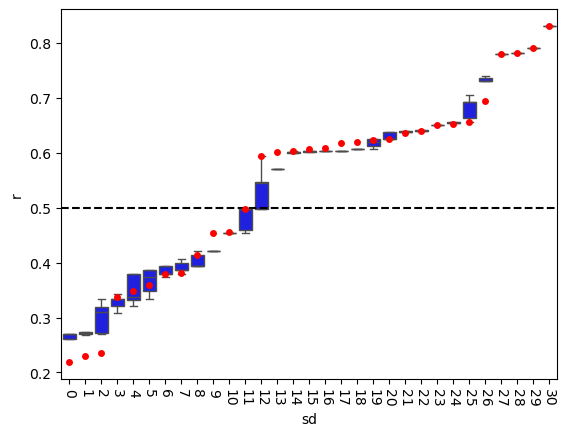

In [6]:
# sns.boxplot(df, x=self.dst, y='r', orient='v', fliersize=1, hue='hue')
# sns.stripplot(
#     df.query('step>0'),
#     x=self.dst,
#     y='r',
#     orient='v',
#     size=3,
#     color='blue',

# )
kwargs = {
    'x':self.dst,
    'y':'r',
    'orient':'v',
}
sns.stripplot(
    df.query('step==0'),
    size=5,
    color='red',
    **kwargs,
)

sns.boxplot(
    df.query('step>0'),
    fliersize=0,
    color='blue',
    # inner='point',
    **kwargs,
)
plt.xticks(rotation=-90)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.show()
# sns.swarmplot(df, x=self.dst, y='r', orient='v', size=2, dodge=False)
# sns.boxplot?

In [54]:
sns.violinplot?


Signature:
sns.violinplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    fill=True,
    inner='box',
    split=False,
    width=0.8,
    dodge='auto',
    gap=0,
    linewidth=None,
    linecolor='auto',
    cut=2,
    gridsize=100,
    bw_method='scott',
    bw_adjust=1,
    density_norm='area',
    common_norm=False,
    hue_norm=None,
    formatter=None,
    log_scale=None,
    native_scale=False,
    legend='auto',
    scale=<deprecated>,
    scale_hue=<deprecated>,
    bw=<deprecated>,
    inner_kws=None,
    ax=None,
    **kwargs,
)
Docstring:
Draw a patch representing a KDE and add observations or box plot statistics.

A violin plot plays a similar role as a box-and-whisker plot. It shows the
distribution of data points after grouping by one (or more) variables.
Unlike a box plot, each violin is drawn using a kernel density estimate
of the underlying dist

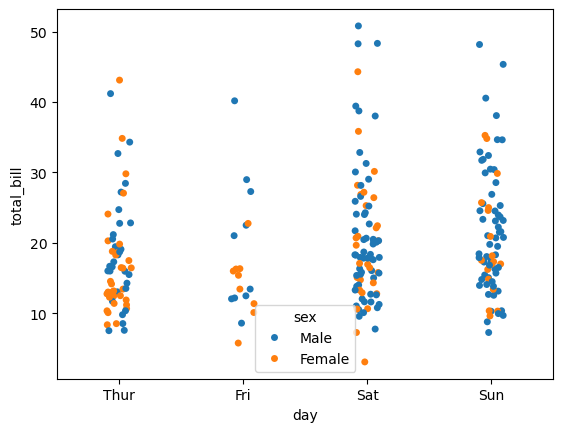

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
tips = sns.load_dataset("tips")

# Create a stripplot with dot colors based on the 'sex' column
sns.stripplot(x="day", y="total_bill", data=tips, hue="sex")

plt.show()


In [4]:
def f(k):
    Q = V.groupby(P[k]).sum().values.T
    return Q[0] / Q.sum(axis=0)
L = [f(k) for k in range(n_step)]

In [10]:
k=2
Q = P.groupby(k)[['d','r']].sum()
R = (Q['d'] / Q.sum(axis=1)).sort_values().values
R

<FloatingArray>
[0.12158939622255058, 0.12349934346276496, 0.14998133088054497,
  0.1528605079330698, 0.16004837413574993,  0.1634412274945843,
 0.16899351834575854, 0.17263997357431046, 0.17648349237687835,
  0.1775472367953927,
 ...
  0.7867563685841711,  0.7899110611109932,  0.7904451024172411,
  0.7964408091079916,   0.803799025638502,  0.8166417639219804,
  0.8404364871456703,  0.8450205828077789,   0.850213555949232,
  0.8528926681945723]
Length: 150, dtype: Float64

In [ ]:
L = [P.groupby(k)[['d','r']].sum().rename_axis('step').reset_index() for k in range(n_step)]

In [3]:
L = [P.groupby(k)[['d','r']].sum().rename_axis('step').reset_index() for k in range(n_step)]

KeyboardInterrupt: 

In [ ]:
L[0]

In [ ]:
df = pd.concat(L, ignore_index=True)
df

In [10]:
for k in self.chain['part']:
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
V = self.vote.query('year==2022').groupby('geoid20').median().sort_index().convert_dtypes()
L = [V.groupby(p).sum() for s,p in self.chain['part'].items()]
# V.groupby(self.chain['part'][0]).sum()
# P = self.chain['part']
# P

KeyboardInterrupt: 

In [ ]:
L[10]

In [2]:
dct = load('/home/pythonserver/gerrymandering/output/tx/chain/2024-10-09_21:59:43/chain.h5')

In [3]:
V = self.vote.query('year==2022').groupby('geoid20').median().sort_index().convert_dtypes()
g = pd.Series(dct['geoid20']).rename('geoid20').convert_dtypes()
P = pd.DataFrame(dct['part'].T, index=g).convert_dtypes()
P

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
geoid20,,,,,,,,,,,,,,,,,,,,,
480019501001000,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
480019501001001,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
480019501001002,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
480019501001003,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
480019501001004,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485079503025020,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
485079503025021,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80
485079503025022,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,80,80


In [4]:
for k,v in dct.items():
    del v

In [5]:
for k,v in V.items():
    P[k] = v
# P['r'] = V['r']

In [8]:
V.groupby(P[1]).sum()

,d,r
1,,
1,11825.0,47011.0
2,10416.0,51219.5
3,12882.0,50731.0
4,16265.5,39717.5
5,10058.0,52785.5
...,...,...
146,32569.5,8634.5
147,36027.0,9208.0
148,20302.0,15713.5


In [6]:
P.groupby(0)

,0,1,2,3,4,5,6,7,8,9,...,9993,9994,9995,9996,9997,9998,9999,10000,d,r
geoid20,,,,,,,,,,,,,,,,,,,,,
480019501001000,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,1.980436,14.067141
480019501001001,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,3.844375,27.306803
480019501001002,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,0.815474,5.792352
480019501001003,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,<NA>,<NA>
480019501001004,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,0.349489,2.482437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485079503025020,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,2.656943,0.981914
485079503025021,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,13.526254,4.998833
485079503025022,80,80,80,80,80,80,80,80,80,80,...,80,80,80,80,80,80,80,80,4.589265,1.696033


In [ ]:
dct = {k: pd.DataFrame(v[:].T).squeeze().convert_dtypes() for k, v in load(fn).items()}

In [2]:
P = self.chain['part']#.sort_index()


In [6]:
V = self.vote.query('year==2022').groupby('geoid20').median().sort_index()
V
# V.reset_index().dtypes
# self.chain['part'] = self.chain['part'].join(V)
# P.index.dtype
# P
# self.vote

,d,r
geoid20,,
480019501001000,1.980436,14.067141
480019501001001,3.844375,27.306803
480019501001002,0.815474,5.792352
480019501001004,0.349489,2.482437
480019501001005,0.698977,4.964873
...,...,...
485079503025020,2.656943,0.981914
485079503025021,13.526254,4.998833
485079503025022,4.589265,1.696033


In [13]:
P = pd.DataFrame(dct['part'].T).set_index(dct['geoid20']).convert_dtypes
            # dct['geoid20'].rename('geoid20', inplace=True)
            # dct['part'].set_index(dct['geoid20'], inplace=True)


In [ ]:
P = P.prep(force_int64=False)

In [15]:
P.reset_index().dtypes

index    int64
0        uint8
1        uint8
2        uint8
3        uint8
         ...  
9996     uint8
9997     uint8
9998     uint8
9999     uint8
10000    uint8
Length: 10002, dtype: object

In [ ]:
part = self.nodes[self.dst].rename('dst')
pairs, pp = self.get_pairs(part)
H = nx.from_pandas_edgelist(pairs.to_pandas(), target='destination')
clr = nx.greedy_color(H)
n_colors = 2*len(set(clr.values()))
clr = nx.equitable_color(H, n_colors)
B = self.blk_simp.assign(clr=C[0])

In [ ]:
import imageio.v3 as iio
import imageio
out = self.chain['fn']().parent / 'animation.mp4'
# frames = np.stack([iio.imread(fn(k)) for k in range(n_steps)], axis=0)
frames = [iio.imread(self.chain['fn'](k)) for k in range(n_steps)]
# with iio.imopen(out, 'w', plugin='FFMPEG') as writer:
#     for img in frames:
#     # for img_file in image_files:
#     #     img = iio.imread(img_file)  # Read each image
#         writer.write(img)  # Write each image to the video

w = imageio.get_writer(out, format='FFMPEG', mode='I', fps=1,
                       # codec='h264_vaapi',
                       # output_params=['-vaapi_device',
                       #                '/dev/dri/renderD128',
                       #                '-vf',
                       #                'format=gray|nv12,hwupload'],
                       # pixelformat='vaapi_vld',
                      )
for fr in frames:
    w.append_data(fr)
# w.append_data(image2)
# w.append_data(image3)
w.close()

In [ ]:
import os
import imageio

out = fn(0).parent / 'animation.gif'
frames = [imageio.imread(fn(k)) for k in range(n_steps)]
imageio.mimsave(out, frames, duration=0.5)

# images = [fn(k) for k in range(n_steps)]
# frames = []
# for image in images:
#     # img_path = os.path.join(image_folder, image)
#     frames.append(imageio.imread(img_path))

# def create_animation(image_folder, output_file, duration=0.5):
#     # Get list of image files in the folder
    
#         # img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]
#     # images.sort()  # Sort images by name

#     # Read images and store them in a list
#     frames = []
#     for image in images:
#         # img_path = os.path.join(image_folder, image)
#         frames.append(imageio.imread(img_path))

#     # Create and save the animation
#     imageio.mimsave(output_file, frames, duration=duration)

#     print(f"Animation saved as {output_file}.")

# # Example usage
# image_folder = 'path_to_image_folder'  # Replace with the path to your folder containing images
# output_file = 'animation.gif'  # Output file name
# create_animation(image_folder, output_file)


In [ ]:
from matplotlib.animation import FuncAnimation
from PIL import Image
fig, ax = plt.subplots()
img = Image.open(fn(0))
im = ax.imshow(img)

def update(k):
    ax.clear()
    img = Image.open(fn(k))
    ax.imshow(img)
    # im.set_array(img)
    # return [im]
ani = FuncAnimation(fig, update, frames=n_steps)#, interval=200)  # interval in milliseconds
# ani.save('animation.mp4', writer='ffmpeg')
ani.save(fn(0).parent / 'animation.gif', writer='pillow', fps=5)  # Adjust fps as needed

In [ ]:

# df = px.data.election()
# geo_df = gpd.GeoDataFrame.from_features(
#     px.data.election_geojson()["features"]
# ).merge(df, on="district").set_index("district")
fig = px.choropleth(geo_df,
                   geojson=geo_df.geometry,
                   locations=geo_df.index,
                   # color="Joly",
                   projection="mercator")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.show()
# fig = px.choropleth_map(geo_df,
#                            geojson=geo_df.geometry,
#                            locations=geo_df.index,
#                            # color="Joly",
#                            # center={"lat": 45.5517, "lon": -73.7073},
#                            # map_style="open-street-map",
#                            # title='World Population Estimates',
#                            # zoom=8.5
#                    )
# fig.update_geos(fitbounds="locations")#, visible=False)
fig.write_html('/home/pythonserver/gerrymandering/test.html')

In [ ]:
import geopandas as gpd
import plotly.express as px

# Load a GeoDataFrame (example: world countries)
gdf = gpd.read_file(path_root / 'ne_110m_admin_1_states_provinces.zip')
    # gpd.datasets.get_path('naturalearth_lowres'))

# Add a column with random data for demonstration
gdf['value'] = 5#gdf['pop_est']  # Example: using population estimates

# Create a choropleth map
fig = px.choropleth(
    gdf,
    geojson=gdf.geometry.__geo_interface__,
    locations=gdf.index,
    color='value',
    hover_name='name',  # Country names for hover
    color_continuous_scale=px.colors.sequential.Plasma,
    title='World Population Estimates',
)

# Update layout
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


In [ ]:
import matplotlib.animation as animation
cm = 'twilight'
fig, ax = plt.subplots()
# im = X[0].plot('clr', cmap=cm)
def generate_image(k):
    ax.clear()
    Y[k].plot('clr', cmap=cm, ax=ax)
    return ax
ani = animation.FuncAnimation(fig, generate_image, frames=3)#, interval=100, blit=True)
# ani.save(path_root / 'test.gif', writer='pillow', fps=3)
ani.save(path_root / 'test.mp4', writer='ffmpeg', fps=10)

# anim = animation.FuncAnimation(
#     fig,
#     generate_image,
#     frames=2,
#     # interval=100,
#     # blit=True,
# )
# anim.save(fn.parent / 'animation.gif', writer='pillow')
# # plt.show()
# # for k, p in P.items():
# #     fig_fn = fn.parent / pattern(k, max(P.columns), 0)
# #     print(fig_fn)
# #     X = self.dissolve(p).assign(clr=clr)
# #     break

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots()

# Set up the grid for the plot (meshgrid)
x = np.linspace(-2, 2, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

# Initialize the image to be displayed
im = ax.imshow(np.zeros((200, 200)), cmap='inferno', vmin=0, vmax=1)

# Function to generate a dynamic expanding circle image
def generate_image(frame):
    radius = 0.1 + frame * 0.05  # The radius increases over time
    distance_from_center = np.sqrt(X**2 + Y**2)  # Distance of each point from the center
    image_data = np.where(distance_from_center < radius, 1, 0)  # Set points inside the circle to 1
    im.set_array(image_data)  # Update the image data in the plot
    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, generate_image, frames=50, interval=100, blit=True)

# Save the animation as a GIF

ani.save(path_root / 'expanding_circle.gif', writer='pillow', fps=10)

print("Animation saved as expanding_circle.gif")


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load your GeoDataFrame (for example, a shapefile)
# Replace this with your actual GeoDataFrame
# gdf= gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = self.vtd_shp

# Example dynamic data: Simulate some changing data (e.g., population growth)
time_steps = 10
gdf['initial_data'] = gdf['pop_est']  # Use population estimate as the initial data
gdf_list = [gdf.copy() for _ in range(time_steps)]  # Copy the GeoDataFrame for each time step

# Simulate data changes over time (for demonstration)
for i, gdf in enumerate(gdf_list):
    gdf['data'] = gdf['initial_data'] * (1 + 0.1 * i)  # Increase data by 10% each step

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Function to update the choropleth plot for each frame
def update(frame):
    ax.clear()  # Clear the previous frame's plot
    gdf_list[frame].plot(column='data', ax=ax, legend=True, cmap='viridis', 
                         legend_kwds={'label': "Population", 'orientation': "horizontal"})
    ax.set_title(f"Time Step {frame + 1}")  # Update the title with the current time step
    return ax

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=500, repeat=True)

# Save the animation as a GIF
ani.save(path_root / 'choropleth_animation.gif', writer='pillow', fps=2)

print("Choropleth animation saved as 'choropleth_animation.gif'")


In [ ]:
w = path_out / "tx/src/VTDs_22G.zip"
w.is_file()
gdf = load(w)
gdf

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load the GeoDataFrame (from a local shapefile)
# Replace this with your actual shapefile path
gdf = gpd.read_file(path_out / "tx/src/VTDs_22G.zip")

# Example dynamic data: Simulate some changing data (e.g., population growth)
time_steps = 10
gdf['initial_data'] = gdf['pop_est']  # Use population estimate or another column as the initial data
gdf_list = [gdf.copy() for _ in range(time_steps)]  # Copy the GeoDataFrame for each time step

# Simulate data changes over time (for demonstration)
for i, gdf in enumerate(gdf_list):
    gdf['data'] = gdf['initial_data'] * (1 + 0.1 * i)  # Increase data by 10% each step

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Function to update the choropleth plot for each frame
def update(frame):
    ax.clear()  # Clear the previous frame's plot
    gdf_list[frame].plot(column='data', ax=ax, legend=True, cmap='viridis', 
                         legend_kwds={'label': "Population", 'orientation': "horizontal"})
    ax.set_title(f"Time Step {frame + 1}")  # Update the title with the current time step
    return ax

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=time_steps, interval=500, repeat=True)

# Save the animation as a GIF
ani.save('choropleth_animation.gif', writer='pillow', fps=2)

print("Choropleth animation saved as 'choropleth_animation.gif'")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize blank image
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
im = ax.imshow(np.zeros((100, 100)), cmap='inferno')

# Function to generate a dynamic expanding circle
def generate_image(frame):
    radius = 0.1 + frame * 0.05  # Increase radius over time
    circle = np.sqrt(X**2 + Y**2)  # Distance from the center
    image_data = np.where(circle < radius, 1, 0)  # Set pixels inside the circle to 1
    im.set_array(image_data)
    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, generate_image, frames=100, interval=100, blit=True)

# Show the animation
# plt.show()
ani.save(path_root / 'expanding_circle.mp4', writer='ffmpeg', fps=10)


In [ ]:
fn.parent / f"{pattern(k, max(P.columns), 0)}.png"

In [ ]:
cmaps = [
    'twilight',
    # 'spectral',
    'brg',
    'coolwarm',
    'flag',
    'gist_ncar',
    'gist_rainbow',
    'gnuplot',
    'hsv',
    'jet',
    'nipy_spectral',
    'rainbow',
    'tab20b',
    'turbo',
]
# for cm in cmaps:
# # for cmap in plt.colormaps():
#     print(cm)
#     R.plot('clr', cmap=cm)
#     plt.show()

In [ ]:
import networkx as nx
R = Q[['geometry']]


E = R.sjoin(R, predicate='intersects').reset_index().set_axis(['source','geo','target'],axis=1)
G = nx.from_pandas_edgelist(E)
color = nx.equitable_color(G,20)
color = pd.Series(color).rename('color')

In [ ]:
# for cmap in plt.colormaps():
#     print(cmap)
#     R.plot(cmap=cmap)
#     plt.show()
    # break